# 1. Configuración de Ambiente

In [1]:
"""
!python -V
print("------")
!pip show Pandas
print("------")
!pip show Matplotlib
"""

'\n!python -V\nprint("------")\n!pip show Pandas\nprint("------")\n!pip show Matplotlib\n'

In [2]:
# !pip install wget

In [3]:
# pip install lightgbm

In [4]:
# Importar librerías a utilizar
import wget
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import FunctionTransformer
from joblib import dump, load
global df_traffic, resultados, modelo, modelo_clasificacion

# 2. Preprocesamiento de Datos

In [5]:
# Leemos el dataset con Pandas y lo cargamos al DataFrame df
df = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/traffic_site.csv')
df.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9674781571160116268,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",9674781571160116268_1472804607,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472804607,1,1472804607
1,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8590648239310839049,"{""continent"": ""Europe"", ""subContinent"": ""Easte...",8590648239310839049_1472835928,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472835928,1,1472835928
2,Affiliates,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9772828344252850532,"{""continent"": ""Americas"", ""subContinent"": ""Sou...",9772828344252850532_1472856802,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""Data Share Promo"", ""source"": ""Pa...",1472856802,1,1472856802
3,Organic Search,20160902,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",1350700416054916432,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",1350700416054916432_1472879649,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472879649,2,1472879649
4,Organic Search,20160902,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",1350700416054916432,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",1350700416054916432_1472829671,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""5"", ""pageviews"": ""4"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472829671,1,1472829671


In [6]:
# Dimensiones del Dataset
df.shape

(12283, 12)

In [7]:
# Información del Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   channelGrouping       12283 non-null  object
 1   date                  12283 non-null  int64 
 2   device                12283 non-null  object
 3   fullVisitorId         12283 non-null  uint64
 4   geoNetwork            12283 non-null  object
 5   sessionId             12283 non-null  object
 6   socialEngagementType  12283 non-null  object
 7   totals                12283 non-null  object
 8   trafficSource         12283 non-null  object
 9   visitId               12283 non-null  int64 
 10  visitNumber           12283 non-null  int64 
 11  visitStartTime        12283 non-null  int64 
dtypes: int64(4), object(7), uint64(1)
memory usage: 1.1+ MB


In [8]:
def preprocesamiento():
    
    # Definimos las variables globales
    global df_traffic, resultados, modelo, modelo_clasificacion
    
    # Extraer datos de diccionarios
    diccionarios = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    # Las columnas que son diccionario, las separamos en el DataFrame
    for columna in diccionarios:
        df_traffic = df_traffic.join(pd.DataFrame([json.loads(linea) for linea in df_traffic[columna]]))
    
    # Creamos lista con los diccionarios a eliminar dentro del DataFrame
    diccionarios2 = ['device', 'geoNetwork', 'totals', 'trafficSource', 'adwordsClickInfo']
    
    # Eliminamos todas las columnas que tienen forma de diccionario
    df_traffic.drop(columns=diccionarios2, inplace=True)

    # Elimina variables con un solo valor
    for columna in df_traffic.columns:
        if len(df_traffic[columna].unique()) == 1:
            df_traffic.drop(columns=[columna], inplace=True)

    # Elimina duplicados
    df_traffic.drop_duplicates(inplace=True)  
    
    # Reemplazar textos por números
    cuant = ['bounces', 'hits', 'newVisits', 'pageviews', 'transactionRevenue']
    for columna in cuant:
        df_traffic[columna] = pd.to_numeric(df_traffic[columna])
    
    # Sustituir valores nulos por ceros
    df_traffic[cuant] = df_traffic[cuant].fillna(0)
    
    # Dividir la variable objetivo 'transactionRevenue' entre 1'000,000
    df_traffic['transactionRevenue'] /= 1000000
    
    # Reemplazar número por fechas
    df_traffic['date'] = pd.to_datetime(df_traffic['date'], format='%Y%m%d')
    df_traffic['visitStartTime'] = pd.to_datetime(df_traffic['visitStartTime'], unit='s')
            

In [9]:
# Carga el dataset al DataFrame df_traffic
df_traffic = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/traffic_site.csv', dtype={'date':object, 'fullVisitorId':object, 'visitId':object})

# Llama a la función para realizar el preprocesamiento
preprocesamiento()

# Muestra aleatoria de 5 filas
df_traffic.sample(5)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,browser,operatingSystem,isMobile,deviceCategory,continent,subContinent,country,region,metro,city,networkDomain,hits,pageviews,bounces,newVisits,transactionRevenue,campaign,source,medium,keyword,isTrueDirect,referralPath,adContent,campaignCode
760,Organic Search,2017-04-20,8939115752207606184,8939115752207606184_1492729682,1492729682,1,2017-04-20 23:08:02,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,algx.net,7,5,0.0,1.0,0.0,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN
932,Social,2016-12-09,8408154357826304157,8408154357826304157_1481279224,1481279224,1,2016-12-09 10:27:04,Chrome,Macintosh,False,desktop,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,ewe-ip-backbone.de,16,16,0.0,1.0,0.0,(not set),quora.com,referral,NaN,NaN,/Where-can-I-buy-a-stuffed-Go-language-gopher-...,NaN,NaN
3010,Referral,2016-09-06,3530473722737134883,3530473722737134883_1473213101,1473213101,1,2016-09-07 01:51:41,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Mountain View,(not set),7,7,0.0,1.0,0.0,(not set),mall.googleplex.com,referral,NaN,NaN,/,NaN,NaN
1197,Organic Search,2016-11-30,2190381549794783486,2190381549794783486_1480564645,1480564645,2,2016-12-01 03:57:25,Chrome,Android,True,mobile,Asia,Southeast Asia,Singapore,(not set),(not set),Singapore,unknown.unknown,3,2,0.0,0.0,0.0,(not set),google,organic,(not provided),True,NaN,NaN,NaN
10986,Direct,2017-04-19,3519136087454236823,3519136087454236823_1492633410,1492633410,1,2017-04-19 20:23:30,Chrome,Android,True,mobile,Americas,Northern America,United States,(not set),(not set),(not set),google.com,1,1,1.0,1.0,0.0,(not set),(direct),(none),NaN,True,NaN,NaN,NaN


In [10]:
# Información de las columnas y sus tipos de datos
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   channelGrouping     12283 non-null  object        
 1   date                12283 non-null  datetime64[ns]
 2   fullVisitorId       12283 non-null  object        
 3   sessionId           12283 non-null  object        
 4   visitId             12283 non-null  object        
 5   visitNumber         12283 non-null  int64         
 6   visitStartTime      12283 non-null  datetime64[ns]
 7   browser             12283 non-null  object        
 8   operatingSystem     12283 non-null  object        
 9   isMobile            12283 non-null  bool          
 10  deviceCategory      12283 non-null  object        
 11  continent           12283 non-null  object        
 12  subContinent        12283 non-null  object        
 13  country             12283 non-null  object    

# 3. Exploración y Feature Engineering

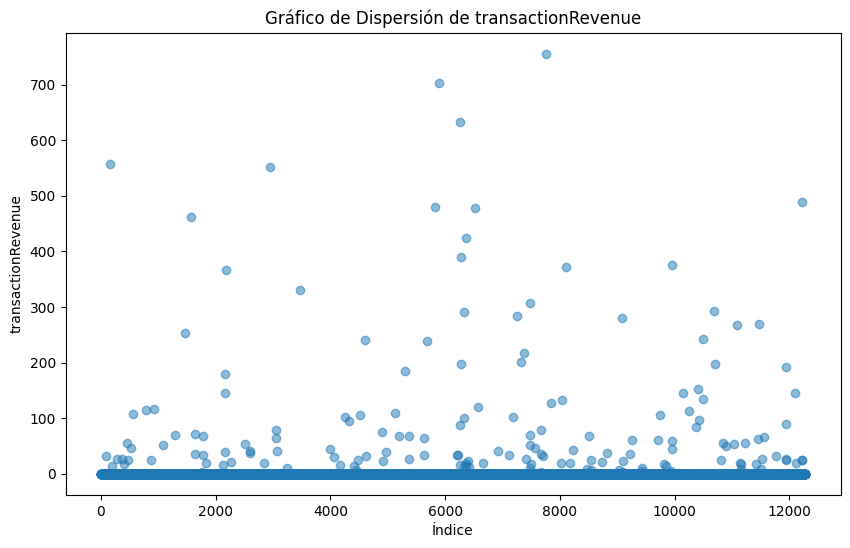

In [11]:
# Gráfico de dispersión (Antes)
plt.figure(figsize=(10,6))
plt.scatter(range(len(df_traffic['transactionRevenue'])), df_traffic['transactionRevenue'], alpha=0.5)
plt.title('Gráfico de Dispersión de transactionRevenue')
plt.xlabel('Índice')
plt.ylabel('transactionRevenue')

plt.show()

<Axes: >

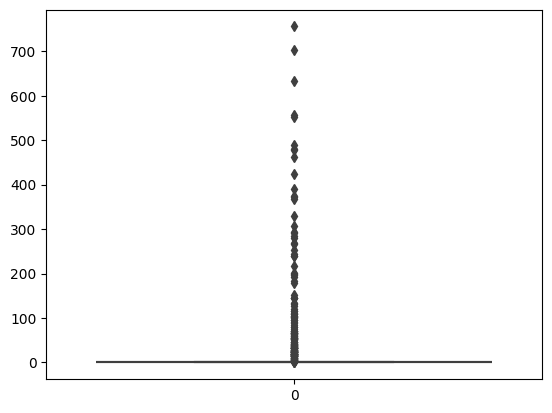

In [12]:
sns.boxplot(df_traffic.transactionRevenue)

In [13]:
df_traffic.describe()

,date,visitNumber,visitStartTime,hits,pageviews,bounces,newVisits,transactionRevenue
count,12283,12283.000000,12283,12283.000000,12283.000000,12283.000000,12283.000000,12283.000000
mean,2017-01-21 17:14:36.040055296,1.923390,2017-01-22 12:17:34.377920768,4.637141,3.871286,0.502483,0.768949,1.447871
min,2016-08-01 00:00:00,1.000000,2016-08-01 07:12:01,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2016-10-27 00:00:00,1.000000,2016-10-28 06:03:31,1.000000,1.000000,0.000000,1.000000,0.000000
50%,2017-01-12 00:00:00,1.000000,2017-01-12 22:03:08,2.000000,1.000000,1.000000,1.000000,0.000000
75%,2017-04-20 00:00:00,1.000000,2017-04-20 11:53:55.500000,4.000000,4.000000,1.000000,1.000000,0.000000
max,2017-08-01 00:00:00,195.000000,2017-08-02 04:28:58,471.000000,305.000000,1.000000,1.000000,755.630000
std,NaN,5.878228,NaN,10.136882,7.273662,0.500014,0.421522,20.893896


In [14]:
conteo = df_traffic['transactionRevenue'].value_counts().sort_values(ascending=False)
conteo

transactionRevenue
0.00      12119
33.59         3
19.19         3
13.59         3
4.99          2
          ...  
7.99          1
269.55        1
62.05         1
8.48          1
25.24         1
Name: count, Length: 147, dtype: int64

Text(0.5, 0, 'transactionRevenue')

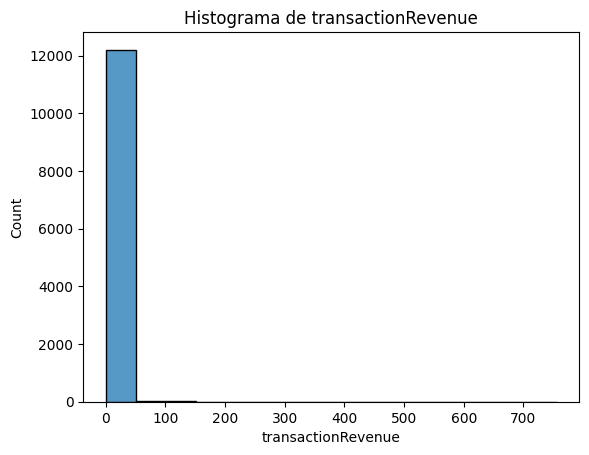

In [15]:
# Histograma (antes)
ax = sns.histplot(data=df_traffic, x='transactionRevenue', kde=False)
ax.set_title('Histograma de transactionRevenue')
ax.set_xlabel('transactionRevenue')

In [16]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   channelGrouping     12283 non-null  object        
 1   date                12283 non-null  datetime64[ns]
 2   fullVisitorId       12283 non-null  object        
 3   sessionId           12283 non-null  object        
 4   visitId             12283 non-null  object        
 5   visitNumber         12283 non-null  int64         
 6   visitStartTime      12283 non-null  datetime64[ns]
 7   browser             12283 non-null  object        
 8   operatingSystem     12283 non-null  object        
 9   isMobile            12283 non-null  bool          
 10  deviceCategory      12283 non-null  object        
 11  continent           12283 non-null  object        
 12  subContinent        12283 non-null  object        
 13  country             12283 non-null  object    

In [17]:
def feature_engineering():
    
    # Definimos las variables globales
    global df_traffic, resultados, modelo, modelo_clasificacion
    
    # Creamos nuevas columnas utilizando df_traffic['date']
    df_traffic['year'] = df_traffic['date'].apply(lambda x:x.year)
    df_traffic['month'] = df_traffic['date'].apply(lambda x:x.month)
    df_traffic['quarterMonth'] = df_traffic['date'].apply(lambda x:x.quarter)
    df_traffic['day'] = df_traffic['date'].apply(lambda x:x.day)
    #df_traffic['weekday'] = df_traffic['date'].apply(lambda x:x.weekday)
    df_traffic['weekday'] = df_traffic['date'].dt.weekday
    
    # Creamos nuevas columnas utilizando df_traffic['visitStartTime']
    df_traffic['time_range'] = pd.cut(df_traffic['visitStartTime'].dt.hour, bins=[0, 6, 12, 18, 24], labels=['madrugada', 'mañana', 'tarde', 'noche'], ordered=False).astype('object')
    
    # Ahora vamos a eliminar algunos atributos que ya no vamos a utilizar
    df_traffic.drop(columns=['date','fullVisitorId','sessionId','visitId','visitStartTime'], inplace=True)
    
    # Ahora seleccionemos todas las variables de tipo object
    # vamos a aplicarles un LabelEncoder para transformarlas a un valor numérico:
    cualitativas = df_traffic.dtypes[df_traffic.dtypes == object].keys()
    
    for columna in cualitativas:
        lbl = LabelEncoder()
        strings = list(df_traffic[columna].values.astype('str'))
        lbl.fit(strings)
        df_traffic[columna] = lbl.transform(strings) 
    
    # Reiniciar el índice del DataFrame
    df_traffic.reset_index(drop=True, inplace=True)

In [18]:
feature_engineering()
df_traffic.sample(5)

,channelGrouping,visitNumber,browser,operatingSystem,isMobile,deviceCategory,continent,subContinent,country,region,metro,city,networkDomain,hits,pageviews,bounces,newVisits,transactionRevenue,campaign,source,medium,keyword,isTrueDirect,referralPath,adContent,campaignCode,year,month,quarterMonth,day,weekday,time_range
11591,6,4,5,6,False,0,2,11,138,130,32,182,0,1,1,1.0,0.0,0.0,0,48,6,85,0,0,11,1,2016,8,3,18,3,4
8284,2,1,18,11,True,2,2,11,138,211,52,295,1686,1,1,1.0,1.0,0.0,0,0,0,85,0,197,11,1,2017,1,1,24,1,3
7513,7,1,5,9,False,0,3,15,142,211,52,295,1567,1,1,1.0,1.0,0.0,0,75,6,85,1,191,11,1,2016,10,4,25,1,4
1850,4,1,5,9,False,0,2,11,19,137,0,271,1207,1,1,1.0,1.0,0.0,0,23,5,4,1,197,11,1,2017,1,1,2,0,3
7515,7,1,18,6,False,0,3,17,55,211,52,295,62,1,1,1.0,1.0,0.0,0,75,6,85,1,129,11,1,2016,10,4,25,1,0


In [19]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   channelGrouping     12283 non-null  int32  
 1   visitNumber         12283 non-null  int64  
 2   browser             12283 non-null  int32  
 3   operatingSystem     12283 non-null  int32  
 4   isMobile            12283 non-null  bool   
 5   deviceCategory      12283 non-null  int32  
 6   continent           12283 non-null  int32  
 7   subContinent        12283 non-null  int32  
 8   country             12283 non-null  int32  
 9   region              12283 non-null  int32  
 10  metro               12283 non-null  int32  
 11  city                12283 non-null  int32  
 12  networkDomain       12283 non-null  int32  
 13  hits                12283 non-null  int64  
 14  pageviews           12283 non-null  int64  
 15  bounces             12283 non-null  float64
 16  newV

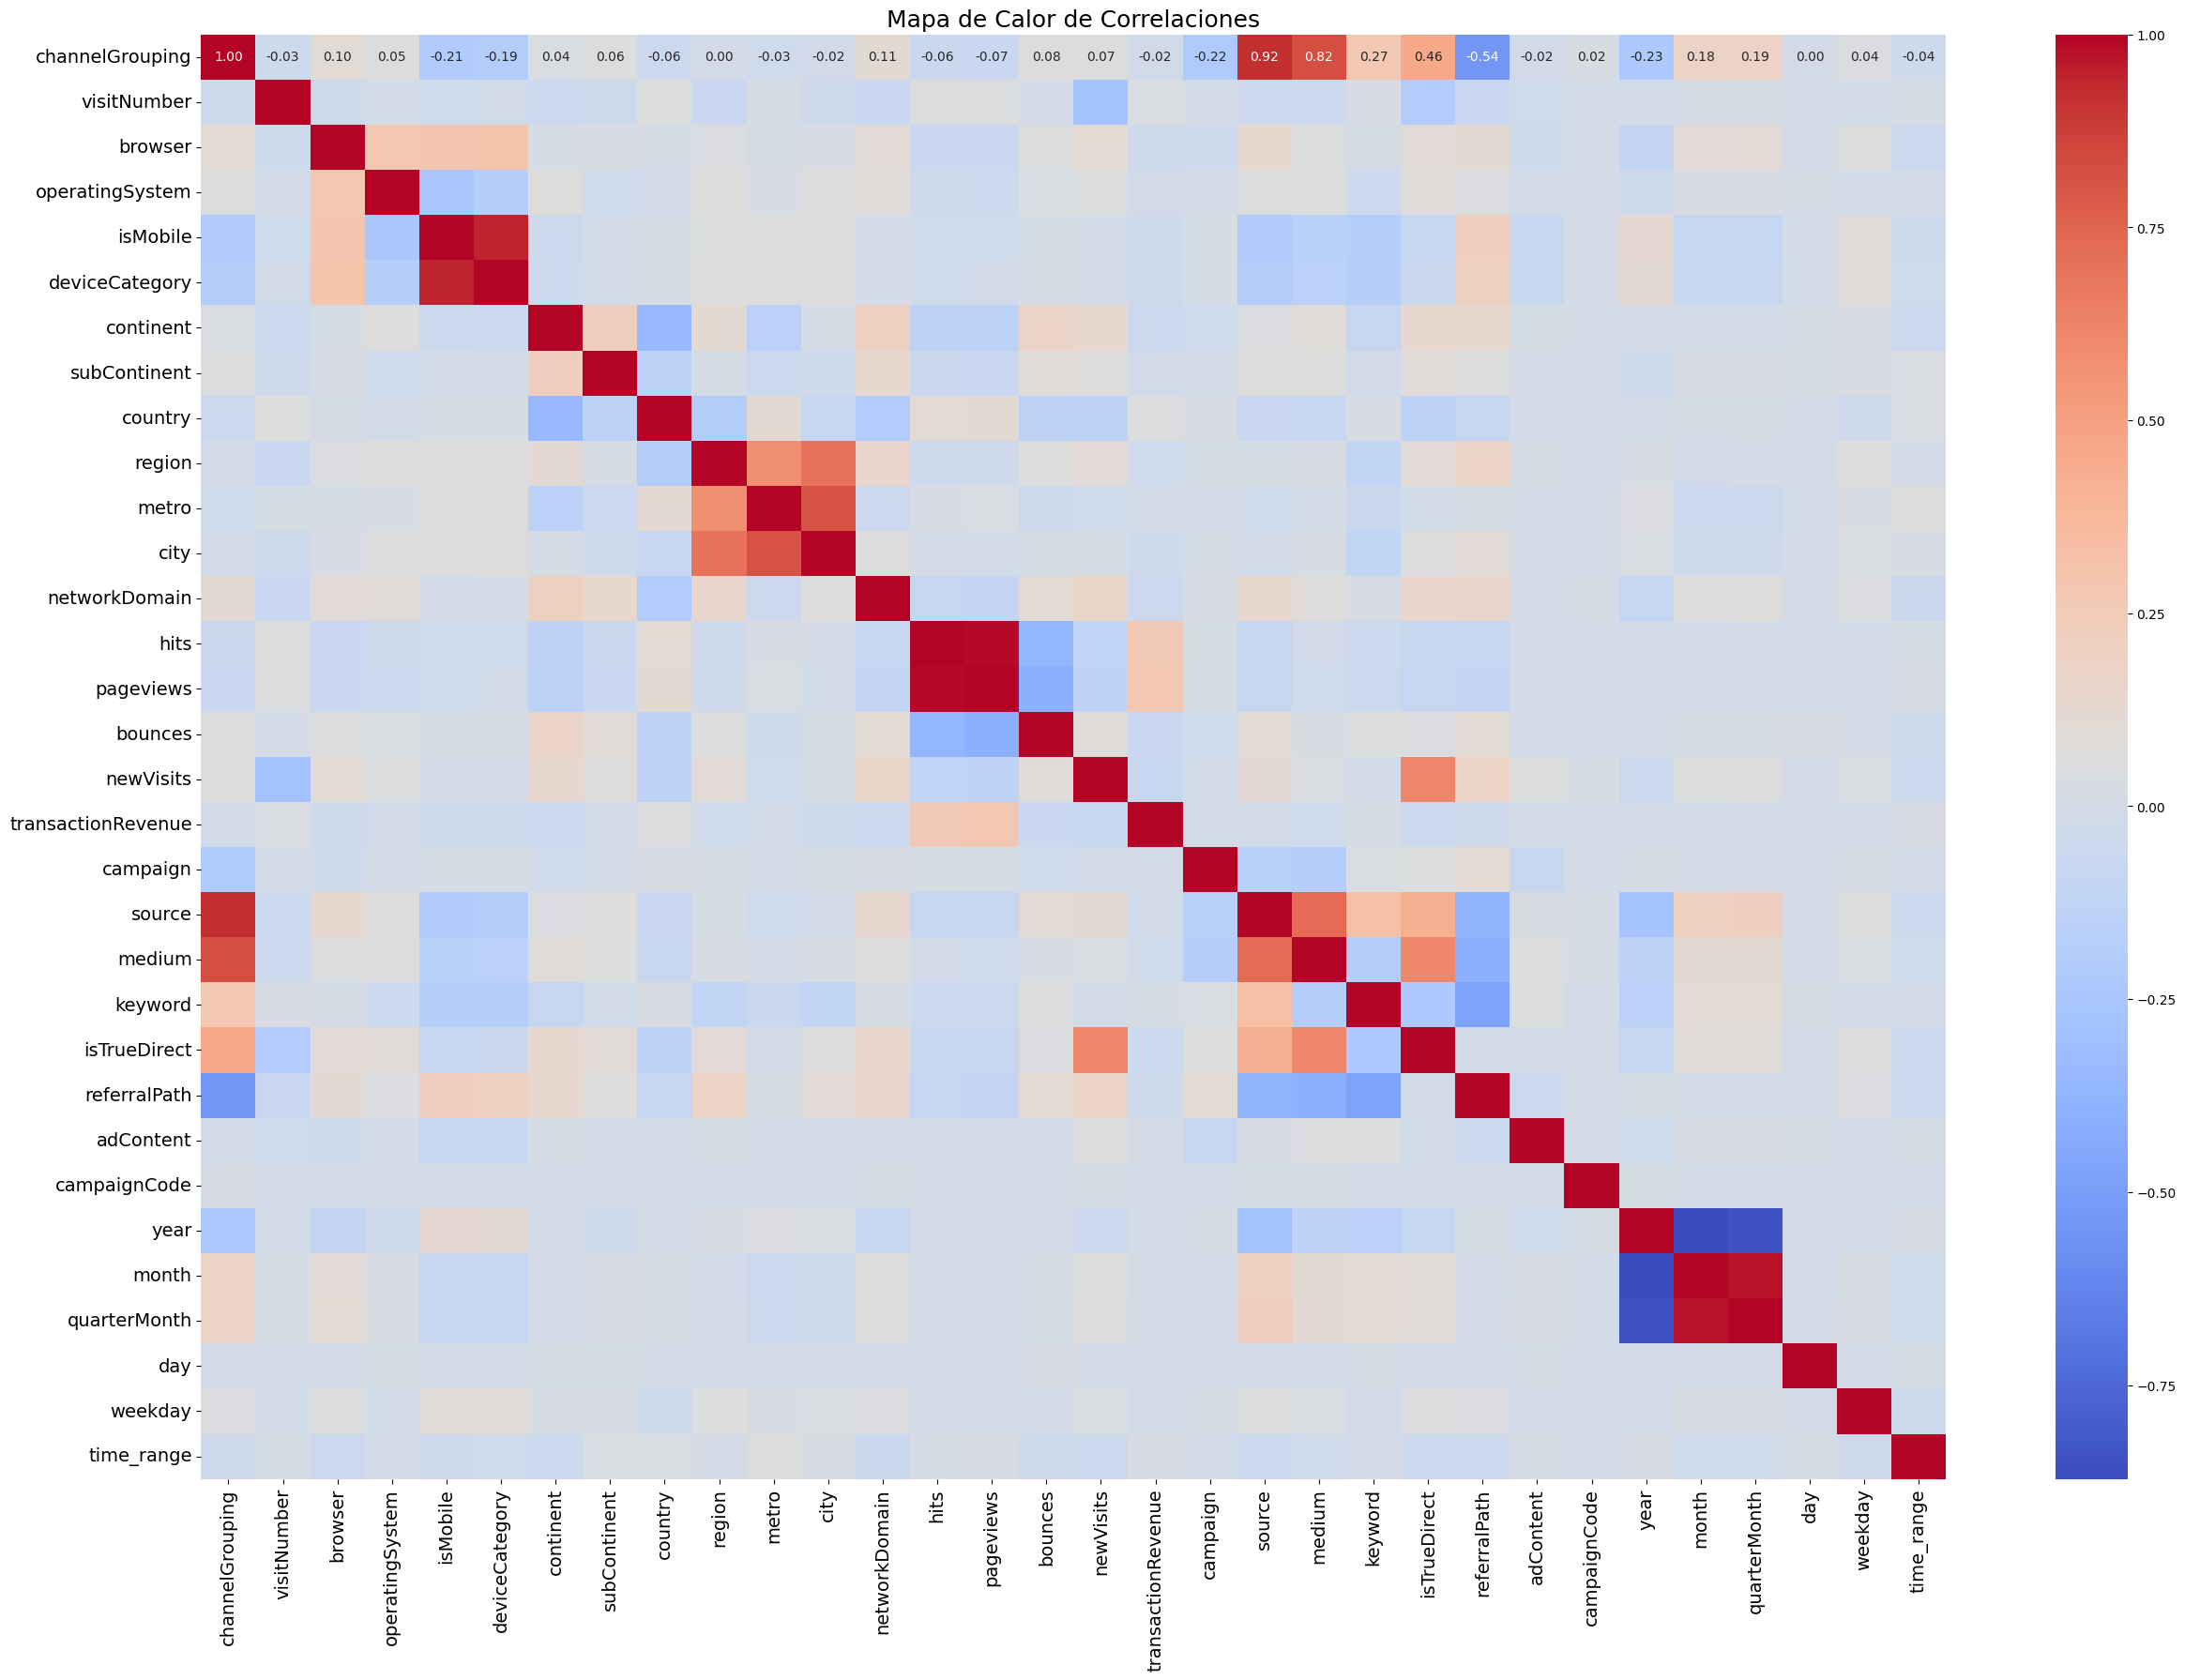

In [20]:
# Gráfico Mapa de Calor
plt.figure(figsize=(30, 20))
heatmap = sns.heatmap(df_traffic.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
heatmap.tick_params(axis='both', which='major', labelsize=14)
plt.title('Mapa de Calor de Correlaciones', fontsize=18)
plt.show()

# 4. Construcción de Modelos

In [21]:
def crea_modelos():
    
    # Definimos las variables globales
    global df_traffic, resultados, modelo, modelo_clasificacion
    
    # Separar en bases de entrenamiento y prueba:
    X = df_traffic.drop('transactionRevenue', axis=1)
    y = df_traffic.transactionRevenue.copy()
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.30, random_state=42)
    
    # Entrenar el modelo de ML
    # Inicializar modelos
    modelos = {
        'Linear Regression': LinearRegression(),
        'Decision Tree Regressor': DecisionTreeRegressor(),
        'Random Forest Regressor': RandomForestRegressor()
    }
    
    # Listas para almacenar métricas
    nombre_modelo = []
    r2 = []
    mse = []
    rmse = []
    
    # Entrenar y evaluar modelos
    for nombre, model in modelos.items():
        # Entrenar modelo
        model.fit(train_x, train_y)
        
        # Realizar predicciones
        predictions = model.predict(test_x)
        predictions[predictions < 0] = 0
        
        # Obtener métricas de la evaluación
        r2_score_value = r2_score(test_y, predictions) * 100
        mse_value = mean_squared_error(test_y, predictions)
        rmse_value = np.sqrt(mse_value)
        
        # Almacenar métricas en listas
        nombre_modelo.append(nombre)
        r2.append(r2_score_value)
        mse.append(mse_value)
        rmse.append(rmse_value)
        
    # Crear diccionario de resultados
    resultados = {
        'Nombre_Modelo': nombre_modelo,
        'R2': r2,
        'MSE': mse,
        'RMSE': rmse
    }
        


In [22]:
crea_modelos()
for i, model in enumerate(resultados['Nombre_Modelo']):
    print('-------------------------------')
    print(f"Modelo: {model}")
    print(f"R-cuadrado (R²): {resultados['R2'][i]}")
    print(f"Error cuadrático medio (MSE): {resultados['MSE'][i]}")
    print(f"Raíz del error cuadrático medio (RMSE): {resultados['RMSE'][i]}")
    print('-------------------------------')

-------------------------------
Modelo: Linear Regression
R-cuadrado (R²): 8.248937805802292
Error cuadrático medio (MSE): 350.2756647058955
Raíz del error cuadrático medio (RMSE): 18.715652932930112
-------------------------------
-------------------------------
Modelo: Decision Tree Regressor
R-cuadrado (R²): -215.89715753094274
Error cuadrático medio (MSE): 1205.9924341655358
Raíz del error cuadrático medio (RMSE): 34.72740177677472
-------------------------------
-------------------------------
Modelo: Random Forest Regressor
R-cuadrado (R²): -7.574444837662764
Error cuadrático medio (MSE): 410.68418468143824
Raíz del error cuadrático medio (RMSE): 20.265344425433245
-------------------------------


# 5. Evaluación y Selección del Modelo

In [23]:
def visualiza_resultados():
    
    # Definimos las variables globales
    global df_traffic, resultados, modelo, modelo_clasificacion
    
    # Crear DataFrame a partir de diccionario
    results_df = pd.DataFrame(resultados)
    results_df.set_index('Nombre_Modelo', inplace=True)
    
    # Visualización
    results_df = results_df.T
    colors = ['#0077b6', '#CDDBF3','#9370DB']
    #colors = ['#0077b6', '#CDDBF3','#9370DB', '#DDA0DD']
    results_df.plot(kind='bar', figsize=(12,6), colormap='viridis', rot=0, color=colors)
    plt.title('Comparación de Métricas por Modelo')
    plt.xlabel('Métricas')
    plt.ylabel('Puntuación')
    plt.legend(title='Modelos')
    plt.tight_layout()
    
    plt.show()

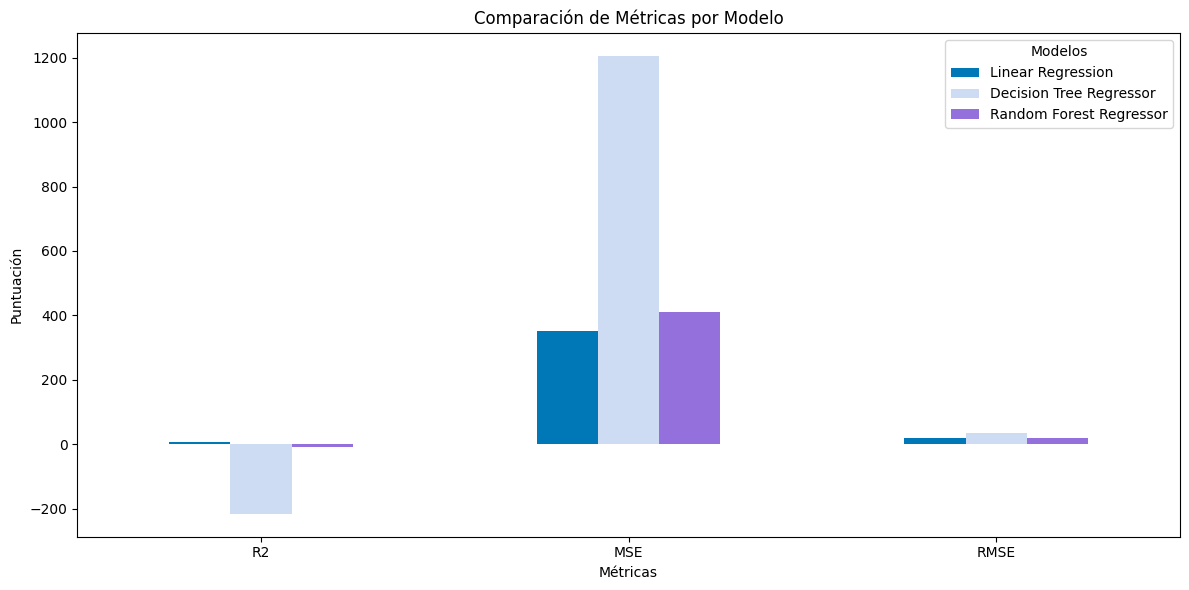

In [24]:
visualiza_resultados()